In [1]:
import os
import pandas as pd
import numpy as np

from glob import glob

import matplotlib.pyplot as plt

from accelerate import Accelerator
accelerator = Accelerator()
device = accelerator.device

In [2]:
target_site = '11238600'
num_adjs = 10
datapath =  '../data/processed'

In [3]:
site_reference = pd.read_csv(os.path.join(datapath, 'site_reference.csv'))
target_lat, target_long = site_reference[site_reference.site_id == int(target_site)].loc[:, ['latitude', 'longitude']].iloc[0,:]
euclidean_dist = lambda lat, long :  np.sqrt((lat - target_lat)**2  + (long - target_long)**2)
site_reference['euclidean_dist'] = site_reference.apply(lambda x: euclidean_dist(x.latitude, x.longitude), axis =1)
observation_sites = site_reference.sort_values('euclidean_dist').iloc[:num_adjs].site_id.astype(str).tolist()

In [4]:
df = pd.read_csv(
            os.path.join(datapath, 'streamflow_sequence.csv'), \
            usecols=['date']+observation_sites,
            parse_dates=['date']
            ).set_index('date')

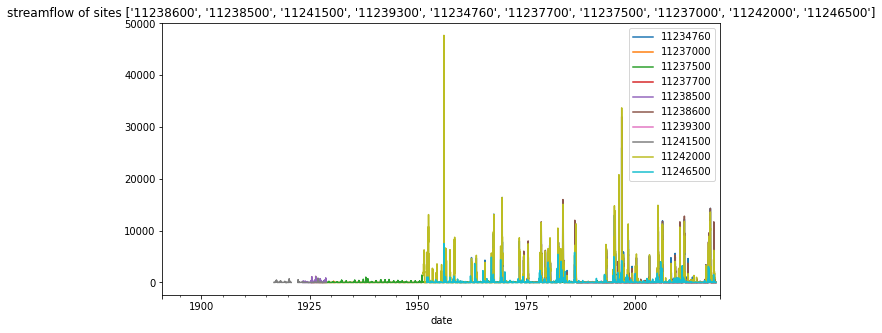

In [5]:
df.plot(figsize=(10, 5))
plt.title(f'streamflow of sites {observation_sites}')
plt.show()

## Trim down the data to sync start and end date

In [6]:
start_date = df.apply(lambda x: x[x.notnull()].index[0]).max()
end_date = df.apply(lambda x: x[x.notnull()].index[-1]).min()

print(f'we choose the dataset starts from {start_date.date()} to {end_date.date()}')

we choose the dataset starts from 1989-01-25 to 2018-09-30


In [7]:
df = df.loc[start_date:end_date,:]

## Missing values

In [8]:
print(f'percentage of missingness between adjacency sites and target sites')
print(df.isnull().mean())
print(f'correlation between adjacency sites and target sites')
print(df.corr()[str(target_site)])

percentage of missingness between adjacency sites and target sites
11234760    0.000000
11237000    0.000000
11237500    0.000000
11237700    0.027119
11238500    0.000000
11238600    0.157735
11239300    0.000000
11241500    0.000000
11242000    0.000000
11246500    0.000000
dtype: float64
correlation between adjacency sites and target sites
11234760    0.961491
11237000    0.241701
11237500    0.764624
11237700    0.743867
11238500    0.567671
11238600    1.000000
11239300    0.329614
11241500    0.470691
11242000    0.961692
11246500    0.443267
Name: 11238600, dtype: float64


In [9]:
adj_sites = df.columns[df.columns.isin(df.isnull().mean()[df.isnull().mean()== 0].index) & \
df.columns.isin(df.corr()[str(target_site)][df.corr()[str(target_site)] > .6].index)]

In [10]:
df = df[adj_sites.tolist() + [target_site]]

In [11]:
null_mask = df[target_site].isnull()

test_dates = df[target_site][null_mask].index.tolist()

print(f'the days of missing: {len(test_dates)}')

the days of missing: 1710


In [12]:
missing_segments = []
segment = []
for i, j in zip(test_dates[1:], test_dates[:-1]):
    if i - j == pd.Timedelta('1d'):
        segment.append(i)
    else:
        missing_segments.append(segment)
        segment = [i]
segment.append(j)
missing_segments.append(segment)

In [13]:
print(f'there are {len(missing_segments)} of missing dates')

for i, segment in enumerate(missing_segments):
    print(f'segment {i}, start date: {segment[0].date()}, end date: {segment[-1].date()}, \
missing days: {len(segment)}')

there are 2 of missing dates
segment 0, start date: 1989-01-26, end date: 1992-09-30, missing days: 1344
segment 1, start date: 1994-10-01, end date: 1995-09-29, missing days: 366


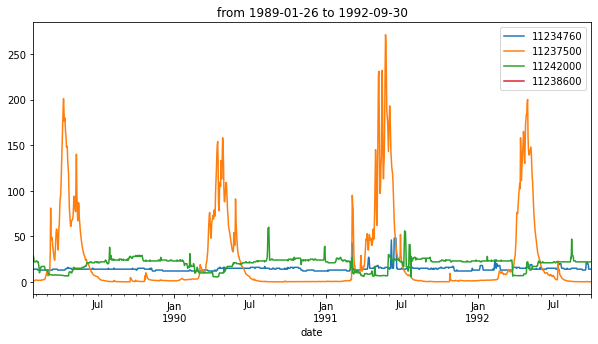

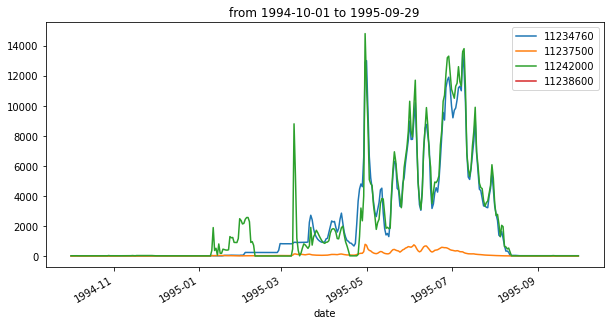

In [14]:
for segment in missing_segments:
    df.loc[segment, :].plot(figsize=(10,5))
    plt.title(f'from {segment[0].date()} to {segment[-1].date()}')
    plt.show()

### we manually make 3 segments of missing data for validation set

In [15]:
train_dates = df.index[~pd.Series(df.index).isin(test_dates)].tolist()

In [16]:
sequence_mean = np.mean(list(map(lambda x: len(x), missing_segments)))
sequence_std = np.std(list(map(lambda x: len(x), missing_segments)))

In [17]:
print(f'length of validation set of each sequence will be {[sequence_mean for _ in range(3)]} days')

length of validation set of each sequence will be [855.0, 855.0, 855.0] days


In [18]:
val_sequence_days = [sequence_mean for _ in range(3)]

In [19]:
def generate_seq(startDate, days):
    toReturn = []
    currDate = startDate
    for _ in range(int(days)-1):
        toReturn.append(currDate)
        currDate = currDate + pd.Timedelta('1d')
    return toReturn

In [20]:
seq_start_dates = [train_dates[(i+1) * len(train_dates)//20] for i in range(2, 20, 6)]

In [21]:
seq_start_dates

[Timestamp('1997-07-01 00:00:00'),
 Timestamp('2004-12-30 00:00:00'),
 Timestamp('2012-07-01 00:00:00')]

In [22]:
val_sequences = [generate_seq(date, day) for date ,day in zip(seq_start_dates,val_sequence_days)]

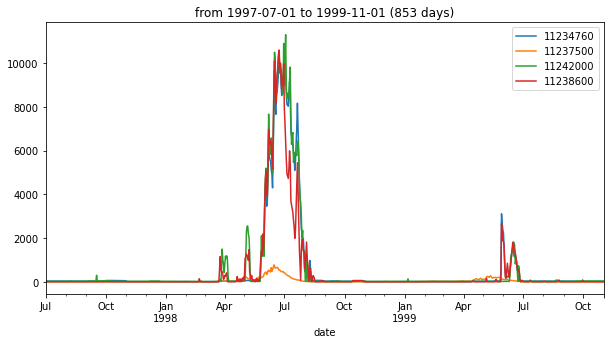

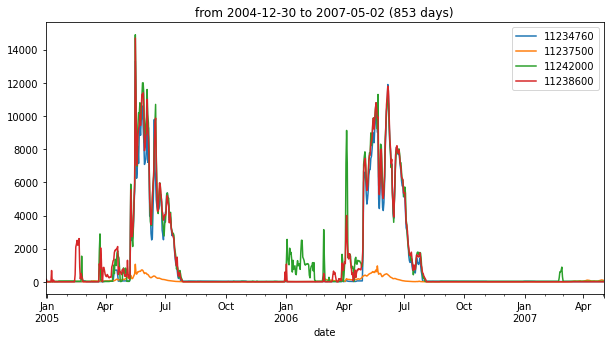

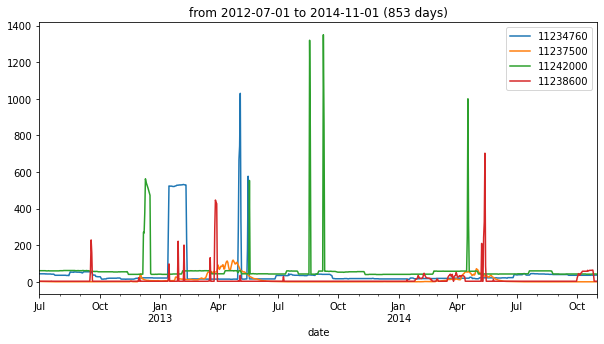

In [23]:
for segment in val_sequences:
    df.loc[segment, :].plot(figsize=(10,5))
    plt.title(f'from {segment[0].date()} to {segment[-1].date()} ({(segment[-1].date() - segment[0].date()).days} days)')
    plt.show()

In [24]:
test_sequences = missing_segments
test_dates = [item for sublist in test_sequences for item in sublist]
val_dates = [item for sublist in val_sequences for item in sublist]

In [25]:
train_dates = [d for d in train_dates if d not in val_dates]
training_sequences = []
segment = []
for i, j in zip(train_dates[1:], train_dates[:-1]):
    if i - j == pd.Timedelta('1d'):
        segment.append(i)
    else:
        training_sequences.append(segment)
        segment = [i]
segment.append(j)
training_sequences.append(segment)

In [26]:
print(f'''
we have {len(train_dates)} days in training set,
    {len(val_dates)} days in validation set,
    {len(test_dates)} days in test set
''')


we have 6569 days in training set,
    2562 days in validation set,
    1710 days in test set



## modeling

In [27]:
train = df.loc[train_dates]
val = df.loc[val_dates]
test = df.loc[test_dates]

def split_xy(x, null_sites):
    X, y = x.drop(null_sites, axis=1).to_numpy(), x[null_sites].to_numpy().squeeze()
    return np.maximum(X, 0), np.maximum(y, 0)
X_train, y_train = split_xy(train, target_site)
X_val, y_val = split_xy(val, target_site)
X_test, _ = split_xy(test, target_site)

In [28]:
train.to

,11234760,11237500,11242000,11238600
date,,,,
1992-10-01,14.0,0.17,22.0,3.1
1992-10-02,14.0,0.17,22.0,3.1
1992-10-03,14.0,0.19,22.0,3.1
1992-10-04,14.0,0.20,22.0,3.1
1992-10-05,14.0,0.20,22.0,3.2
...,...,...,...,...
2018-09-26,30.0,0.30,48.0,3.6
2018-09-27,29.0,0.30,47.0,3.6
2018-09-28,30.0,0.30,47.0,3.6


### Baseline: Linear Models

In [28]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
def evaluate(pred, df, val_sequences, null_sites):
    val_dates = [item for sublist in val_sequences for item in sublist]
    y_val = df.loc[val_dates, null_sites].to_numpy().squeeze()
    print(f'root mean squared error: {np.sqrt(metrics.mean_squared_error(y_val, val_pred))}')
    print(f'r2 score {metrics.r2_score(y_val, val_pred)} \n')
    for ix, segment in enumerate(val_sequences):
        sub_df = df.loc[segment, :][null_sites]
        sub_df.columns = ['true']
        sub_df['predict'] = val_pred[ix: ix + len(segment)]
        
        print(f'segment root mean squared error: {np.sqrt(metrics.mean_squared_error(sub_df.true, sub_df.predict))}')
        print(f'segment r2: {metrics.r2_score(sub_df.true, sub_df.predict)}')
        
        display(sub_df.plot(figsize = (10, 5)))
        plt.title(f'from {segment[0].date()} to {segment[-1].date()} ({(segment[-1].date() - segment[0].date()).days} days)')
        plt.show()

root mean squared error: 414.1311194206303
r2 score 0.9512684170635687 

segment root mean squared error: 615.2328917131158
segment r2: 0.85877442312901


<AxesSubplot:xlabel='date'>

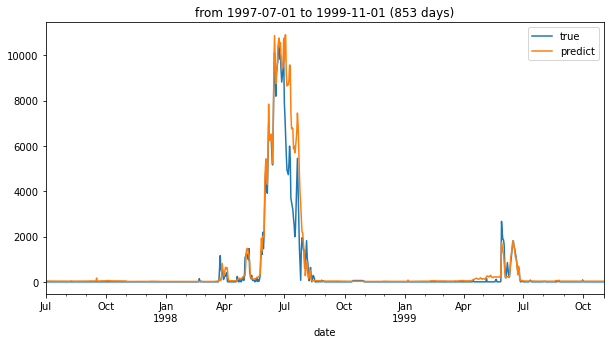

segment root mean squared error: 3584.512375269796
segment r2: -0.8111945031755297


<AxesSubplot:xlabel='date'>

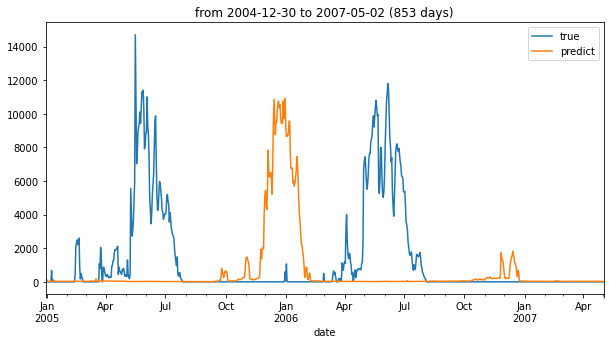

segment root mean squared error: 2071.5300402496878
segment r2: -2307.2264130453163


<AxesSubplot:xlabel='date'>

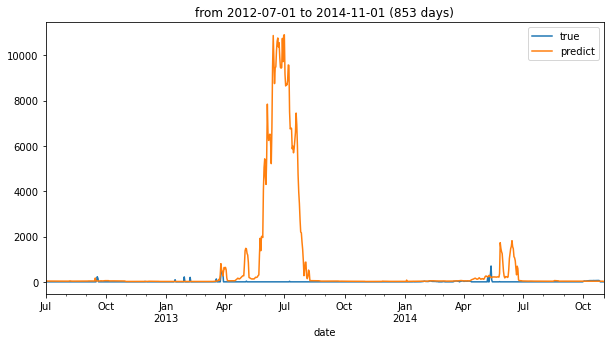

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)
val_pred = lr.predict(X_val)
evaluate(val_pred, df, val_sequences, [target_site])

### MLP for adjacency prediction

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)
train_df = df.copy()
X_train, y_train = [F.relu(torch.FloatTensor(t)) for t in split_xy(train_df.loc[train_dates], [target_site])]
X_val, y_val = [F.relu(torch.FloatTensor(t)) for t in split_xy(train_df.loc[val_dates], [target_site])]
X_test, y_test = [F.relu(torch.FloatTensor(t)) for t in split_xy(train_df.loc[test_dates], [target_site])]

In [35]:
def _train(model, X, y, optimizer, scheduler, criterion):
    model.train()
    pred = model(X.to(device)).squeeze()
    true = y.to(device)
    
    optimizer.zero_grad()
    loss = criterion(pred, true)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def _evaluate(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        pred = model(X.to(device)).squeeze()
        true = y.to(device)
        loss = criterion(pred, true)
        return loss.item()
def train(model, X_train, y_train, X_val, y_val, optimizer, scheduler, criterion, num_epochs):
    for e in range(num_epochs):
        train_loss = _train(model, X_train, y_train, optimizer, scheduler, criterion)
        eval_loss = _evaluate(model, X_val, y_val, criterion)
        if (e + 1) % 100 == 0:
            print(f'epoch: {e + 1}, train loss: {train_loss}, val loss: {eval_loss}')
    return model

In [36]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(X_train.shape[1], 64),
                nn.ReLU(),
                nn.Dropout(.3),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Dropout(.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(.3),
                nn.Linear(64, 1)
            )
    def forward(self, x):
#         x = F.normalize(x)
        return self.fc(x)

In [37]:
device = 'cuda'

model = MLP().to(device)

LR = 1e-2
NUM_EPOCHS = 500

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=.5)

In [38]:
model = train(model, X_train, y_train, X_val, y_val, optimizer, scheduler, criterion, NUM_EPOCHS)

epoch: 100, train loss: 254068.390625, val loss: 138605.515625
epoch: 200, train loss: 240432.640625, val loss: 161230.0
epoch: 300, train loss: 230412.3125, val loss: 179211.625
epoch: 400, train loss: 239534.890625, val loss: 186981.09375
epoch: 500, train loss: 276225.53125, val loss: 186650.53125


root mean squared error: 432.0306937001833
r2 score 0.9469648268629819 

segment root mean squared error: 450.1045151771718
segment r2: 0.9244105813993116


<AxesSubplot:xlabel='date'>

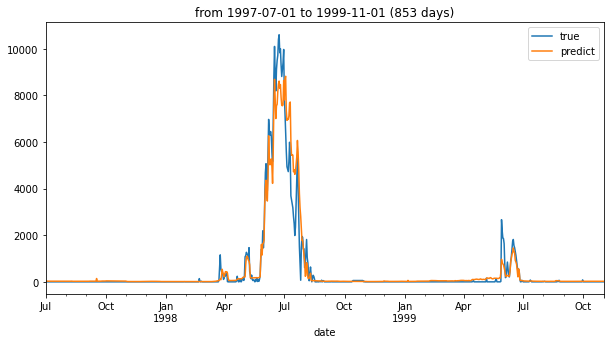

segment root mean squared error: 3367.9640717645216
segment r2: -0.5989681871938315


<AxesSubplot:xlabel='date'>

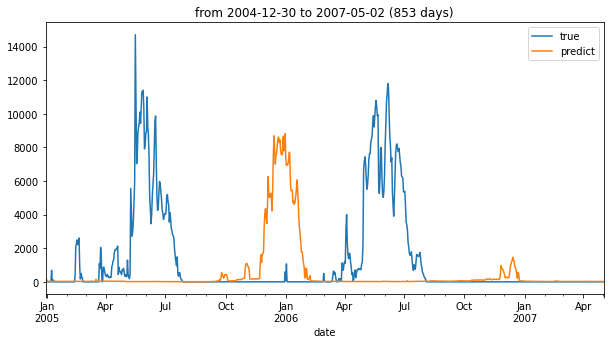

segment root mean squared error: 1664.577676319509
segment r2: -1489.4042049222687


<AxesSubplot:xlabel='date'>

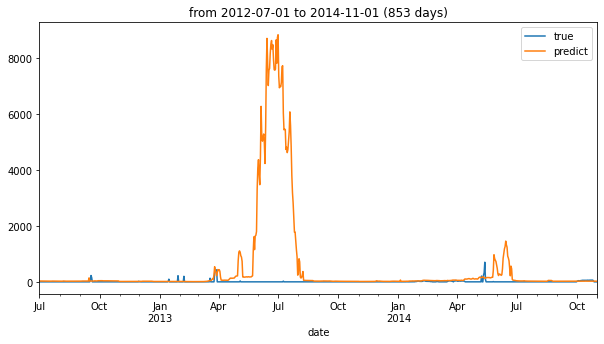

In [39]:
model.eval()
with torch.no_grad():
    val_pred = model(X_val.to(device)).squeeze().detach().cpu().numpy()
evaluate(val_pred, df, val_sequences, [target_site])

### LSTM for adjacency prediction

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)
train_df = df.copy()
# train_df.loc[val_dates, null_sites] = lr.predict(train_df.loc[val_dates].drop(null_sites,axis=1)).reshape(-1, 1)
# train_df.loc[test_dates, null_sites] = lr.predict(train_df.loc[test_dates].drop(null_sites,axis=1)).reshape(-1, 1)
X_train, y_train = [F.relu(torch.FloatTensor(t)) for t in split_xy(train_df.loc[train_dates], [target_site])]
X_val, y_val = [F.relu(torch.FloatTensor(t)) for t in split_xy(train_df.loc[val_dates], [target_site])]
X_test, y_test = [F.relu(torch.FloatTensor(t)) for t in split_xy(train_df.loc[test_dates], [target_site])]

In [41]:
def split_sequence(t, sequences):
    prev_len = 0
    cut_idx = []
    for seq in sequences:
        cut_idx.append((prev_len, prev_len + len(seq)))
        prev_len += len(seq)
    
    if t.dim() == 1:
        return [t[idx[0]: idx[1]] for idx in cut_idx]
    else:
        return [t[idx[0]: idx[1], :] for idx in cut_idx]

In [55]:
def _train(model, X, y, optimizer, scheduler, criterion, sequences):
    model.train()
    optimizer.zero_grad()
    X_splits, y_splits = split_sequence(X, sequences), split_sequence(y, sequences)
    
    avg_loss = 0.0
    for x_batch, y_batch in zip(X_splits, y_splits):
        
        preds = model(x_batch.to(device))
        preds = preds.squeeze()
        trues = y_batch.to(device)
        loss = criterion(preds, trues)
        avg_loss += loss
        
    avg_loss.backward()
    optimizer.step()
    scheduler.step()
        
    return np.sqrt(avg_loss.item() / len(X_splits))

def _evaluate(model, X, y, criterion, sequences):
    model.eval()
    X_splits, y_splits = split_sequence(X, sequences),split_sequence(y, sequences)
    avg_loss = 0.0
    
    with torch.no_grad():
        for x_batch, y_batch in zip(X_splits, y_splits):
            preds = model(x_batch.to(device))
            preds = preds.squeeze()
            trues = y_batch.to(device)
            loss = criterion(preds, trues)
            avg_loss += loss 
            
    return np.sqrt(avg_loss.item() / len(X_splits))

def train(model, 
          X_train, y_train, X_val, y_val, 
          optimizer, scheduler, criterion, 
          num_epochs,
          train_sequences, val_sequences
         ):
    best_eval_loss = float(np.inf)
    best_model = model
    for e in range(num_epochs):
        train_loss = _train(model, X_train, y_train, optimizer, scheduler, criterion, train_sequences)
        eval_loss = _evaluate(model, X_val, y_val, criterion, val_sequences)
        if best_eval_loss > eval_loss:
            best_eval_loss = eval_loss
            best_model = model
        if (e + 1) % 5 == 0:
            print(f'epoch: {e + 1}, train loss: {train_loss}, val loss: {eval_loss}')
    print(f'best val loss: {best_eval_loss}')
    return best_model

In [62]:
class lstmModel(nn.Module):
    def __init__(self):
        super(lstmModel, self).__init__()
        self.lstm1 = nn.LSTM(
                    input_size=X_train.shape[1],
                    hidden_size=32, 
                    batch_first=True,
                    num_layers = 5,
                    bidirectional = True
                )
        self.fc = nn.Sequential(
                        nn.Linear(32 * 2, 64),
                        nn.ReLU(),
                        nn.Linear(64, 128),
                        nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 1)
                    )
    def forward(self, x):
        x = x.unsqueeze(0)
#         x = torch.sqrt(x)
        x, _ = self.lstm1(x)
        x = x.squeeze()
#         x = torch.tanh(x)
        return self.fc(x)

In [63]:
model = lstmModel().to(device)

LR = 1e-2
NUM_EPOCHS = 200

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=.5)

In [64]:
model = train(
              model, 
              X_train, y_train, X_val, y_val, 
              optimizer, scheduler, criterion, 
              NUM_EPOCHS,
              training_sequences, val_sequences
             )

epoch: 5, train loss: 1826.772673323093, val loss: 1960.3791299984127
epoch: 10, train loss: 1793.4597848850697, val loss: 1917.0272994056884
epoch: 15, train loss: 1742.2856252635502, val loss: 1900.1914815793345
epoch: 20, train loss: 1730.7325616628355, val loss: 1878.927530977889
epoch: 25, train loss: 1744.2823165990073, val loss: 1884.387433623988
epoch: 30, train loss: 1729.3333975841674, val loss: 1877.0806233794717
epoch: 35, train loss: 1730.0190750393476, val loss: 1875.3256606076006
epoch: 40, train loss: 1728.554077834998, val loss: 1877.1210225591033
epoch: 45, train loss: 1727.952024796985, val loss: 1873.748915943649
epoch: 50, train loss: 1725.8975635882912, val loss: 1875.7845469740566
epoch: 55, train loss: 1724.6506312873921, val loss: 1872.2521197744709
epoch: 60, train loss: 1726.7835417330107, val loss: 1874.8400820692236
epoch: 65, train loss: 1724.7402703015896, val loss: 1871.0542482782266
epoch: 70, train loss: 1725.1362844714617, val loss: 1879.37560553144
e

root mean squared error: 1768.9276128477388
r2 score 0.1108912000742287 

segment root mean squared error: 1462.5028318538566
segment r2: 0.20195441879253506


<AxesSubplot:xlabel='date'>

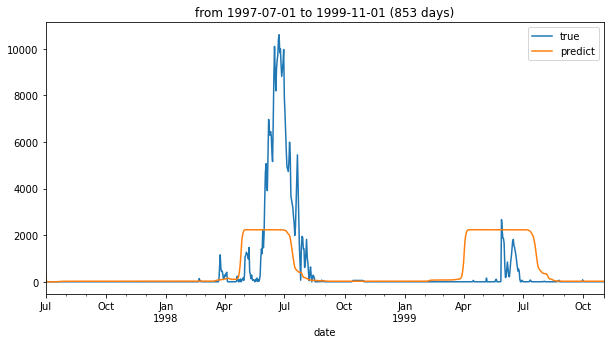

segment root mean squared error: 3107.271391823126
segment r2: -0.361016205755599


<AxesSubplot:xlabel='date'>

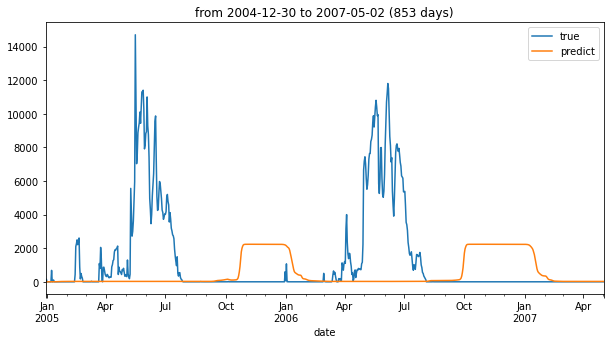

segment root mean squared error: 1031.0279065859327
segment r2: -570.7902899195909


<AxesSubplot:xlabel='date'>

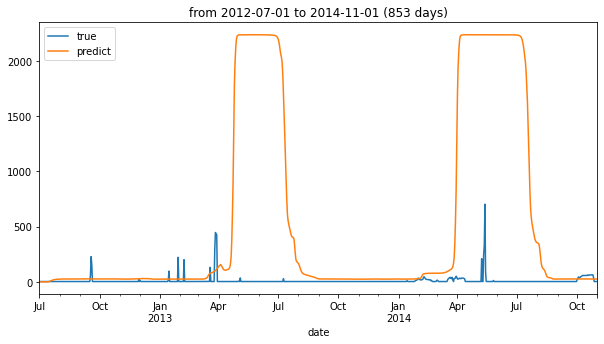

In [65]:
model.eval()
with torch.no_grad():
    val_pred = model(X_val.to(device)).squeeze().detach().cpu().numpy()
evaluate(val_pred, df, val_sequences, [target_site]) 